In [1]:
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.api as smtsa
from statsmodels.tsa import arima_process

## Load in Data and Set Index

In [4]:
min_temp_data = pd.read_csv('/Users/ryangeygan/hacking/Datasets/daily-min-temperatures.csv')

In [5]:
min_temp_data.set_index('Date', inplace=True)
min_temp_data.index = pd.date_range(start=min_temp_data.index[0], periods=len(min_temp_data), freq='D')
min_temp_data = min_temp_data.rename(columns={'Temp':'min_temp'})

## Brief EDA

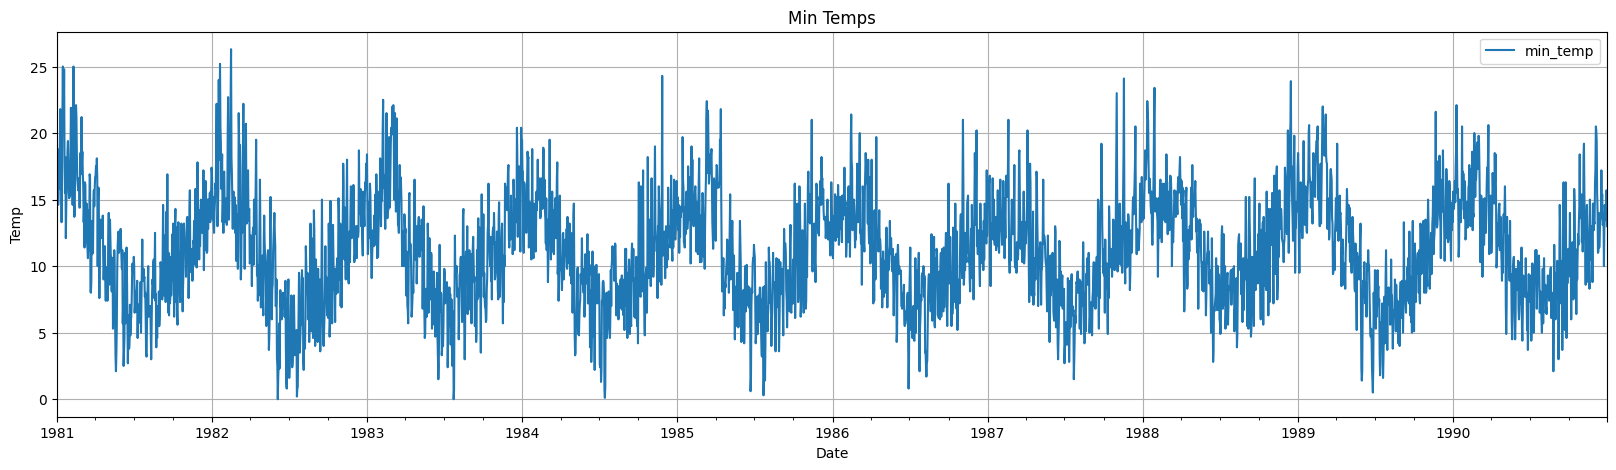

In [6]:
plt.rcParams['figure.figsize'] = [20, 5]

# Plotting
min_temp_data.plot()
plt.title('Min Temps')
plt.xlabel('Date')
plt.ylabel('Temp')
plt.grid(True)
plt.show()

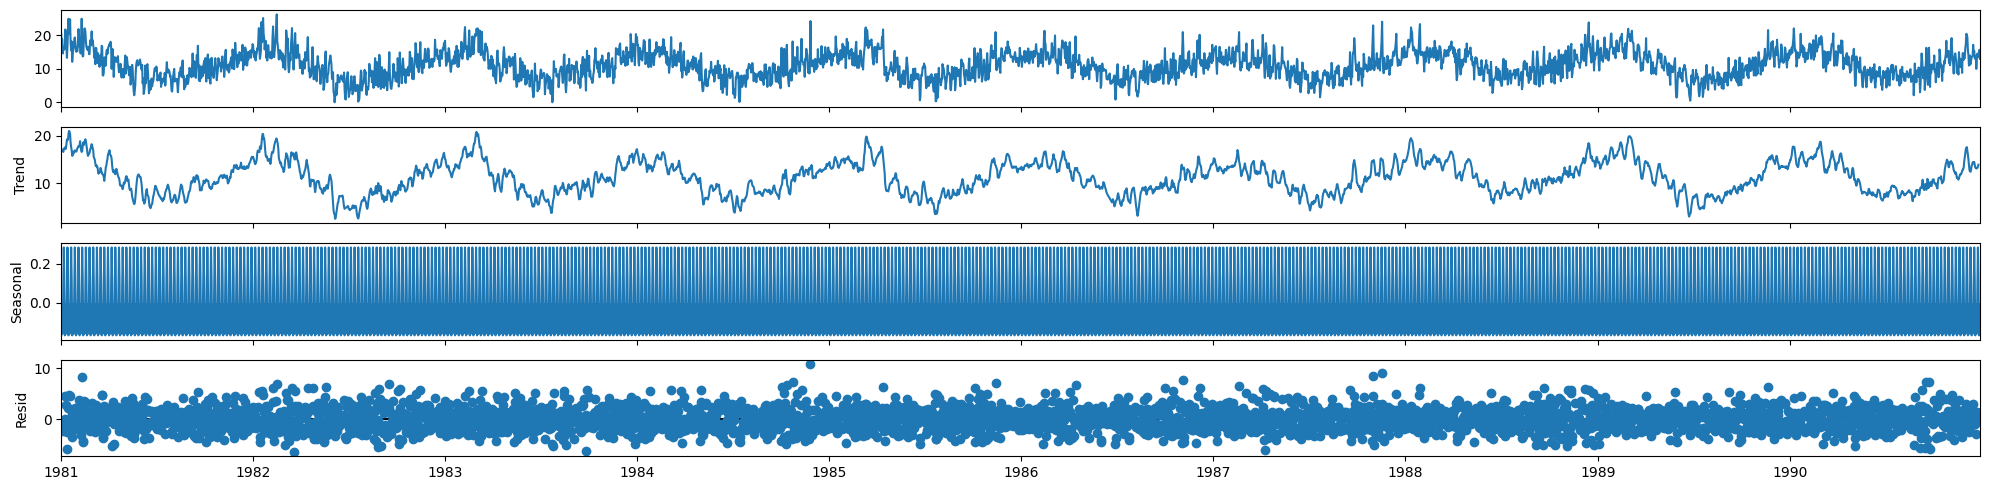

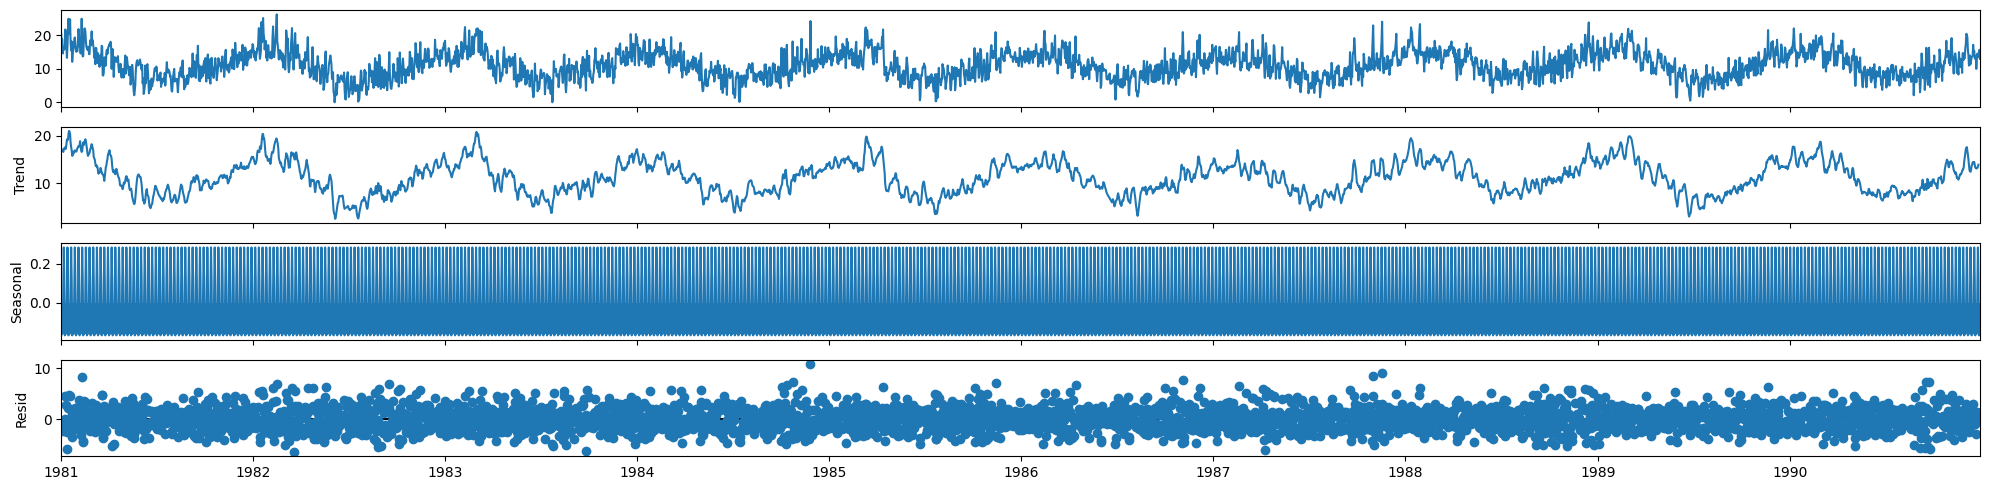

In [7]:
results = seasonal_decompose(min_temp_data)

results.plot()

## Resample the Data to Monthly and Repeat

/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_11225/523218344.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = min_temp_data.resample('M').mean()


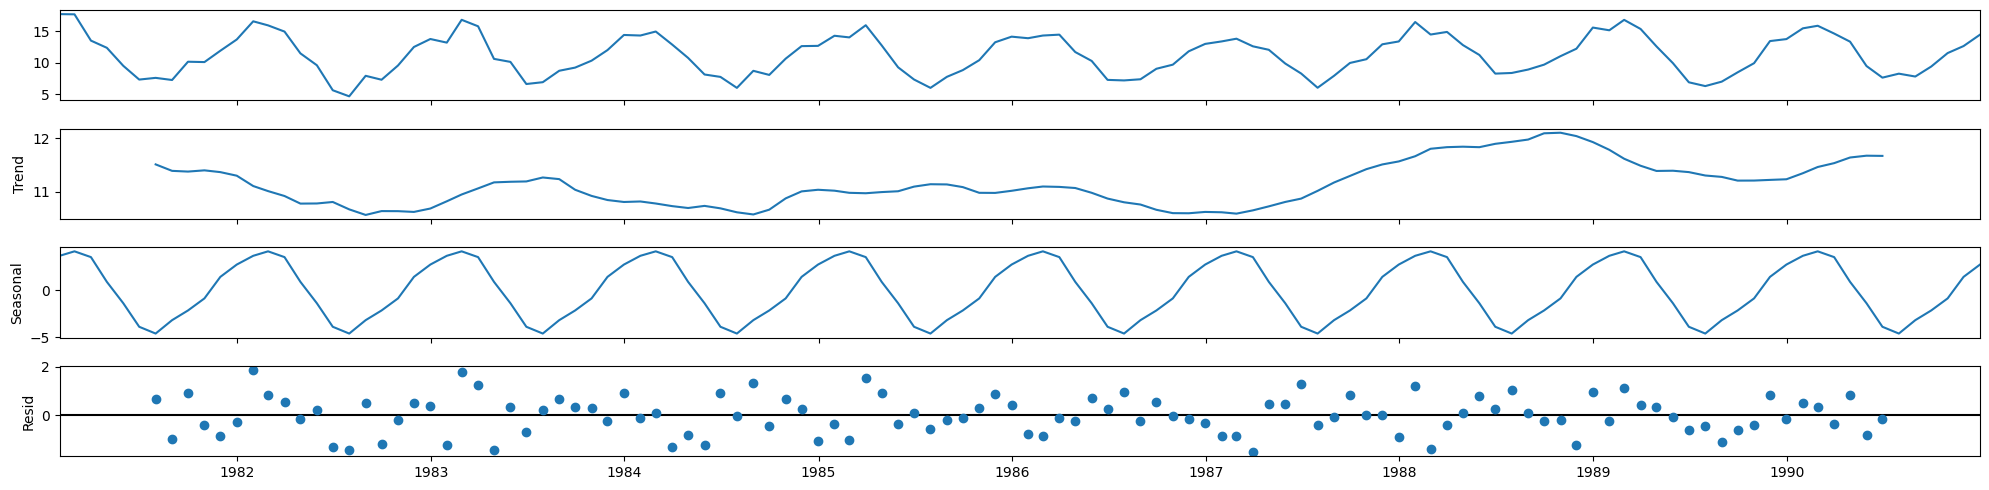

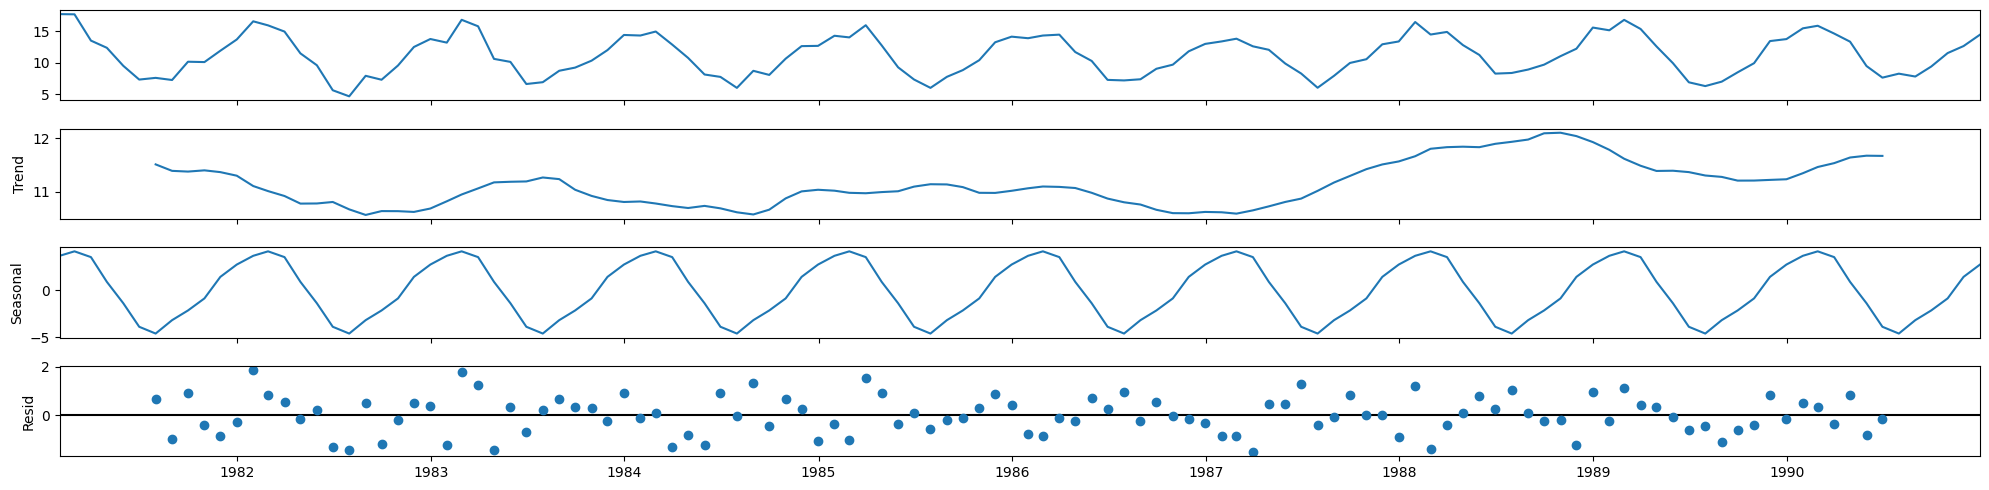

In [8]:
df_monthly = min_temp_data.resample('M').mean()

results2 = seasonal_decompose(df_monthly)

results2.plot()

In [20]:
df_monthly.head()

min_temp
1981-01-31  17.712903
1981-02-28  17.678571
1981-03-31  13.500000
1981-04-30  12.356667
1981-05-31   9.490323

In [21]:
df_monthly.tail()

min_temp
1990-08-31   7.790323
1990-09-30   9.376667
1990-10-31  11.519355
1990-11-30  12.633333
1990-12-31  14.444828

## Start With An ARMA Model

### Plot ACF and PACF

In [16]:
## Function courtsey of Tertiary Courses https://www.youtube.com/watch?v=tfAQMqWUAL8

def plotds(xt, nlag=30, fig_size=(12,10)):
    if not isinstance(xt, pd.Series):
        xt = pd.Series(xt)
    plt.figure(figsize = fig_size)
    layout = (2,2)

    #Assign axes
    ax_xt = plt.subplot2grid(layout, (0,0), colspan=2)
    ax_acf = plt.subplot2grid(layout, (1,0))
    ax_pacf = plt.subplot2grid(layout, (1,1))

    #Plot
    xt.plot(ax = ax_xt)
    plot_acf(xt, lags=50, ax=ax_acf)
    plot_pacf(xt, lags=50, ax=ax_pacf)
    plt.tight_layout()
    return

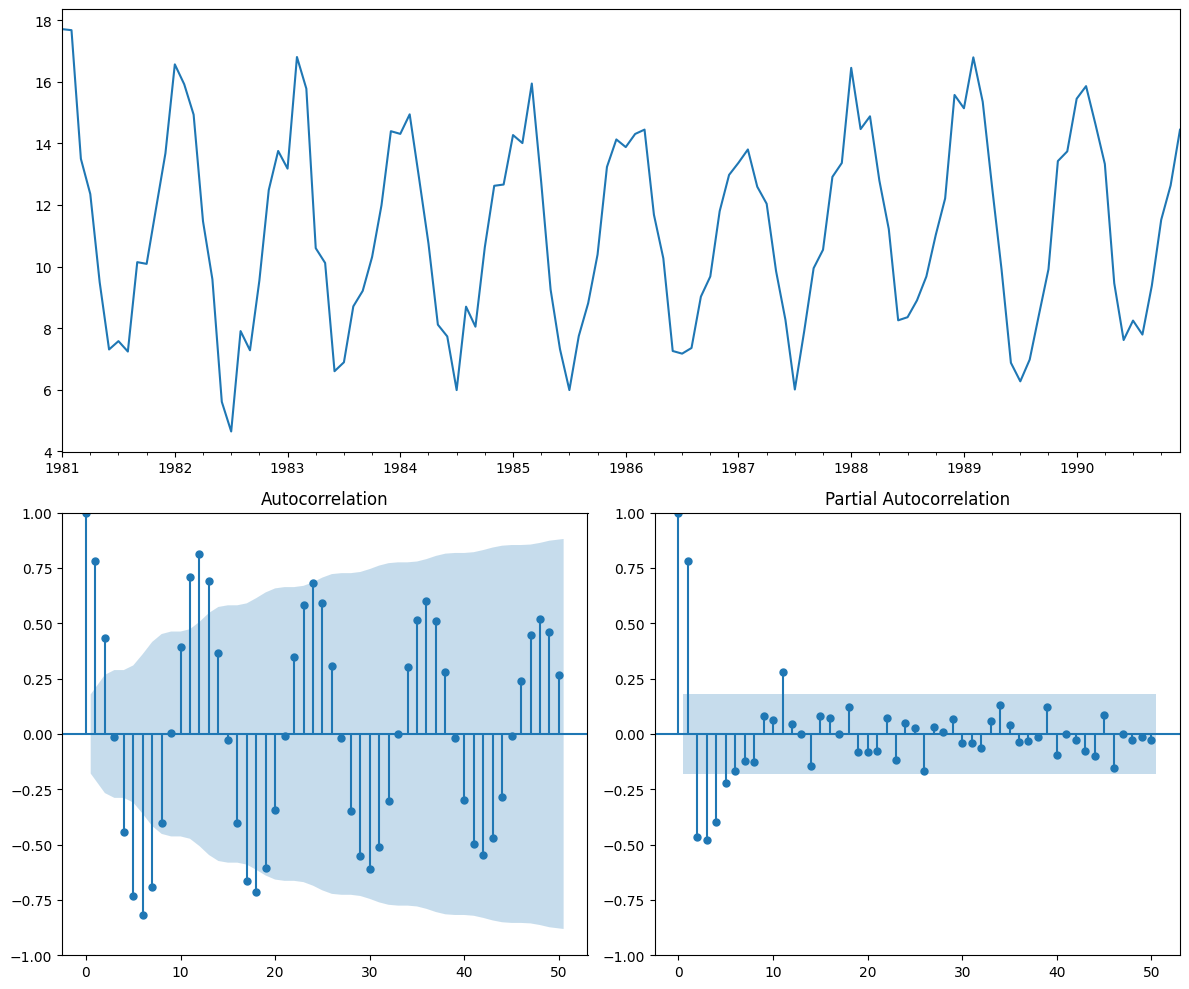

In [17]:
data = df_monthly.min_temp

plotds(data)

## Fit an ARMA Model

In [24]:
# order (p, d, q)
## the data is relatively "stationary" meaning that there is no strong trend in the mean over time so we can try d = 0
## p is the number of AR parameters - the PACF plot tells us something about "direct" correlation between data at a point in time 
## and another value at a particular lag - looks like there is significant correlation from 5 previous months so we can try p = 5
## q is the number of MA parameters - the ACF plot tells us something about the combined affect of auto correlation from all previous time periods
## looks like 2 or 3 are significantly correlated so let's try q = 2

model = ARIMA(df_monthly['min_temp'], order=(5, 0, 2))

# Fit

trained_model = model.fit()

# Summary

trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               min_temp   No. Observations:                  120
Model:                 ARIMA(5, 0, 2)   Log Likelihood                -186.462
Date:                Thu, 21 Mar 2024   AIC                            390.923
Time:                        10:42:35   BIC                            416.011
Sample:                    01-31-1981   HQIC                           401.111
                         - 12-31-1990                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.1763      0.111    100.551      0.000      10.958      11.394
ar.L1          0.1591      0.224      0.710      0.478      -0.280       0.598
ar.L2          0.8973      0.118      7.632      0.000       0.667       1.128
ar.L3         -0.3421      0.208     -1.646      0.100      -0.750       0.065
ar.L4         -0.4806      0.093     -5.183      0.000      -0.662      -0.299
ar.L5         -0.1538      0.169     -0.912      0.362      -0.484       0.177
ma.L1          0.4012      0.201      1.991      0.046       0.006       0.796
ma.L2         -0.5252      0.150     -3.504      0.000      -0.819      -0.231
sigma2         1.2598      0.190      6.629      0.000       0.887       1.632
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.02
Prob(Q):                              0.78   Prob(JB):                         0.99
Heteroskedasticity (H):               0.55   Skew:                            -0.00
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Create Training and Testing Data then Normalize Data

In [25]:
start_date = '1981-01-31'
end_date = '1990-12-31'

df_monthly['forecast'] = trained_model.predict(start = start_date, end = end_date)

In [26]:
df_monthly

min_temp   forecast
1981-01-31  17.712903  11.176328
1981-02-28  17.678571  16.483360
1981-03-31  13.500000  15.745020
1981-04-30  12.356667  10.695910
1981-05-31   9.490323   8.571638
...               ...        ...
1990-08-31   7.790323   7.542272
1990-09-30   9.376667   8.803997
1990-10-31  11.519355  10.930790
1990-11-30  12.633333  12.666694
1990-12-31  14.444828  14.087240

[120 rows x 2 columns]

## Plot the Result

<Axes: >

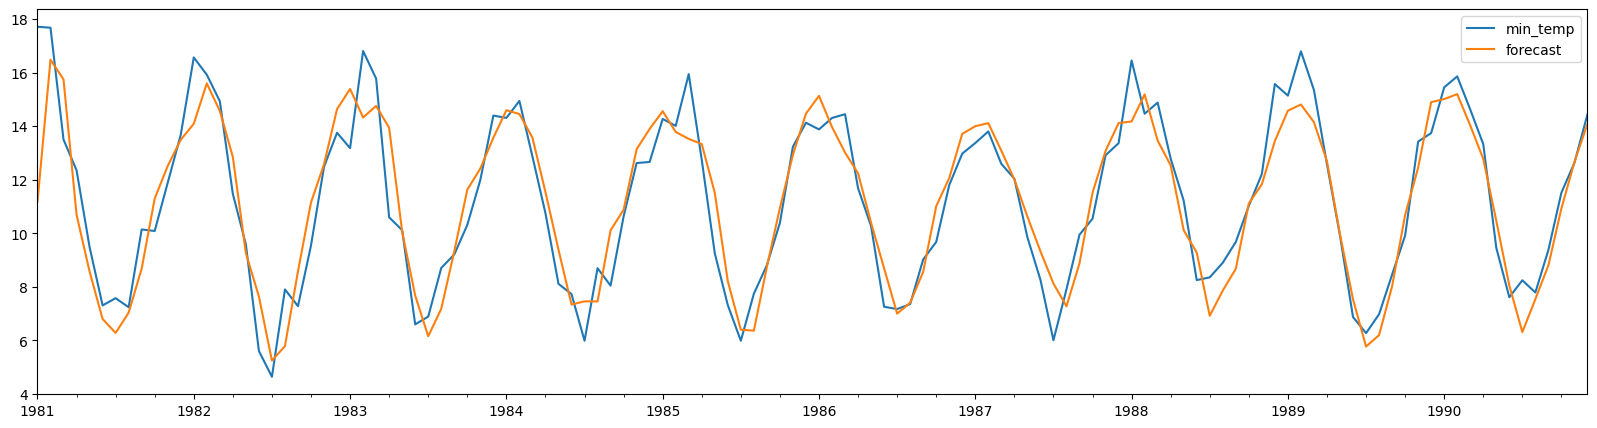

In [27]:
df_monthly[['min_temp', 'forecast']].plot()

In [7]:
#Let's train the LSTM on 8 years of data and see how well it predicts the last two
train = df_monthly[:96]
test = df_monthly[96:]

In [8]:
# Scale data to range 0 - 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train.values)
scaled_test = scaler.fit_transform(test.values)

### Define the Time Series Generator
This parses the input data into "batches" - sets of data for training. The data scientist can play with the "lookback" period which is the size of the time window for training. For example, in this daily dataset if the lookback was 365, we would be passing it batches of 365 sequential data points at a time to predict the 366th value. Then the window would move one day forward and use days 2 - 366 to predict the 367th value. Temperature has daily and yearly periodicity so it's up to the scientist to decide how to allocate computing resources. Training on larger windows creates a larger model.

In [9]:
#generator using a 30 day window
look_back = 12 #the time window
n_features = 1 #the number of predictor features (we have 1 - time)

train_generator = TimeseriesGenerator(scaled_train, scaled_train,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

test_generator = TimeseriesGenerator(scaled_test, scaled_test,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 10)

# Create a Simple LSTM Model

In [10]:
#Initializie model class
model = Sequential()
model.add(Input(shape=(look_back,n_features)))
#We will only add 1 LSTM cell block because there is only 1 input feature to predict temp (time)
model.add(LSTM(150))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150)            │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,351 (356.84 KB)

 Trainable params: 91,351 (356.84 KB)

 Non-trainable params: 0 (0.00 B)

## Fit the Model

In [12]:
model.fit(train_generator, epochs=300, verbose=False)

/Users/ryangeygan/hacking/machine-learning/.venv-machine-learning/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [13]:
test_predictions = []

first_eval_batch = scaled_train[-look_back:]
current_batch = first_eval_batch.reshape((1, look_back, n_features))

for i in range(len(test) + 24):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch, verbose=False)[0]
    
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
     

In [14]:
transformed_pred = scaler.inverse_transform(test_predictions)

predictions = [x[0] for x in transformed_pred]

my_preds_list = [np.nan] * (144 - 48) + predictions

# Extend the DataFrame by 24 months
extension_dates = pd.date_range(start=df_monthly.index[-1] + pd.DateOffset(months=1), periods=24, freq='M')  # Add 24 months
extension_data = {'value': [None] * 24}  # Fill with None or NaN values, or specify your own values
extension_df = pd.DataFrame(extension_data, index=extension_dates)
extended_df = pd.concat([df_monthly, extension_df]).drop(columns=['value'])

extended_df['predicted_temp'] = my_preds_list

/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_42109/985468261.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  extension_dates = pd.date_range(start=df_monthly.index[-1] + pd.DateOffset(months=1), periods=24, freq='M')  # Add 24 months


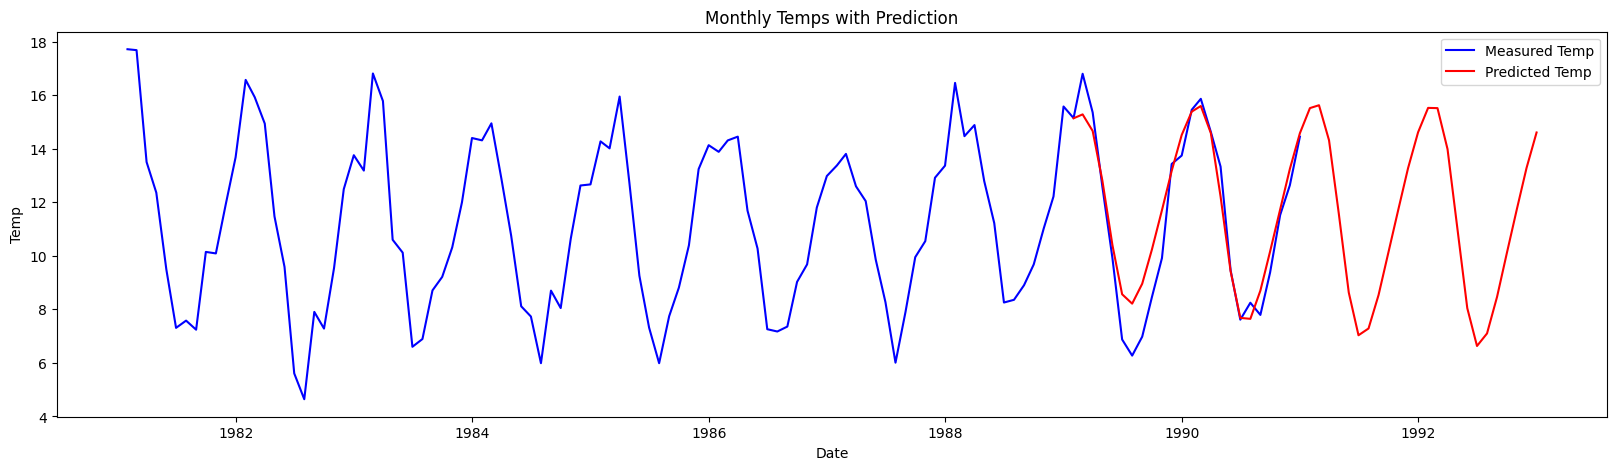

In [15]:
# Plotting
plt.rcParams['figure.figsize'] = [20, 5]

# Plot col1 in blue
plt.plot(extended_df.index, extended_df['min_temp'], color='blue', label='Measured Temp')

# Plot col2 in red
plt.plot(extended_df.index, extended_df['predicted_temp'], color='red', label='Predicted Temp')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Temp')
plt.title('Monthly Temps with Prediction')
plt.legend()

# Show plot
plt.show()

## Try to Improve the Model by Adding Another Source of Data
Let's see if we can add monthly max temps to the LSTM model to help predict the monthly min temps

In [16]:
max_temp_data = pd.read_csv('/Users/ryangeygan/hacking/Datasets/daily-max-temperatures.csv')

max_temp_data.set_index('Date', inplace=True)
max_temp_data.index = pd.date_range(start=min_temp_data.index[0], periods=len(min_temp_data), freq='D')
max_temp_data = max_temp_data.rename(columns={'Temperature':'max_temp'})

/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_42109/1340362331.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly_max = max_temp_data.resample('M').mean()


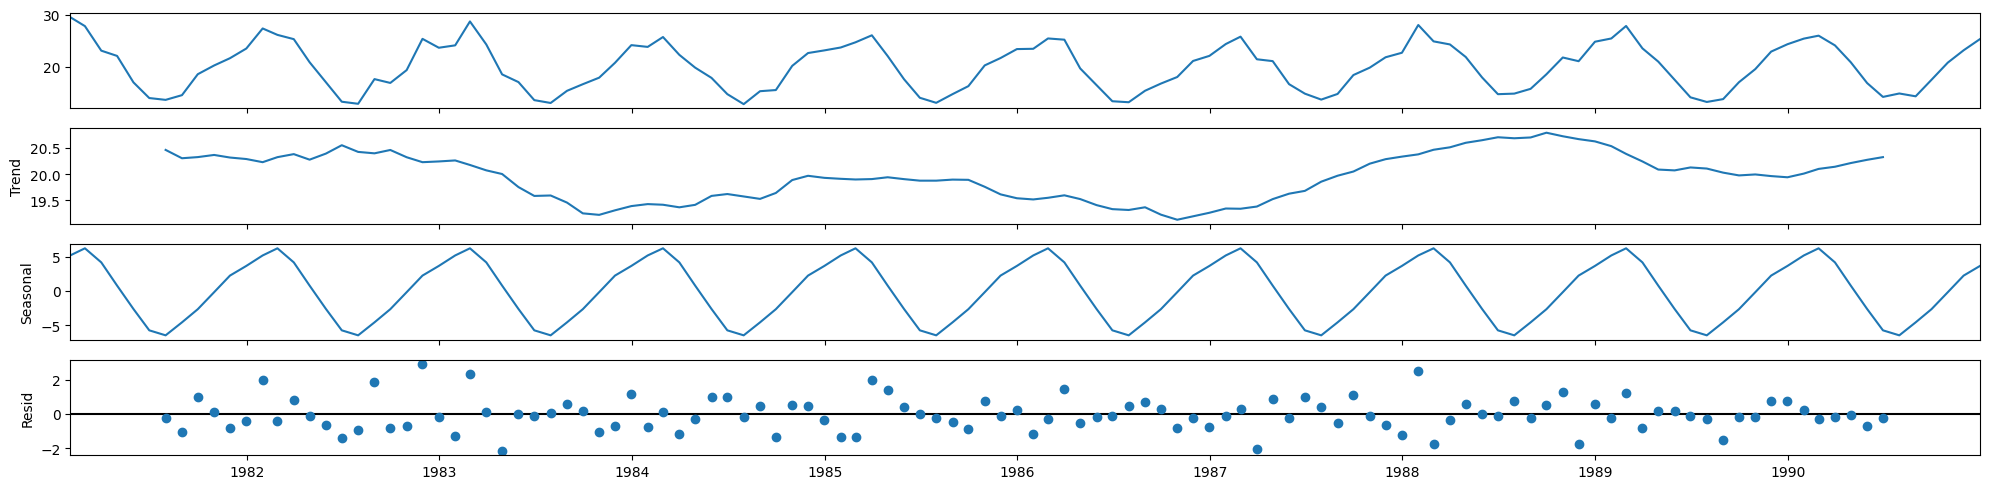

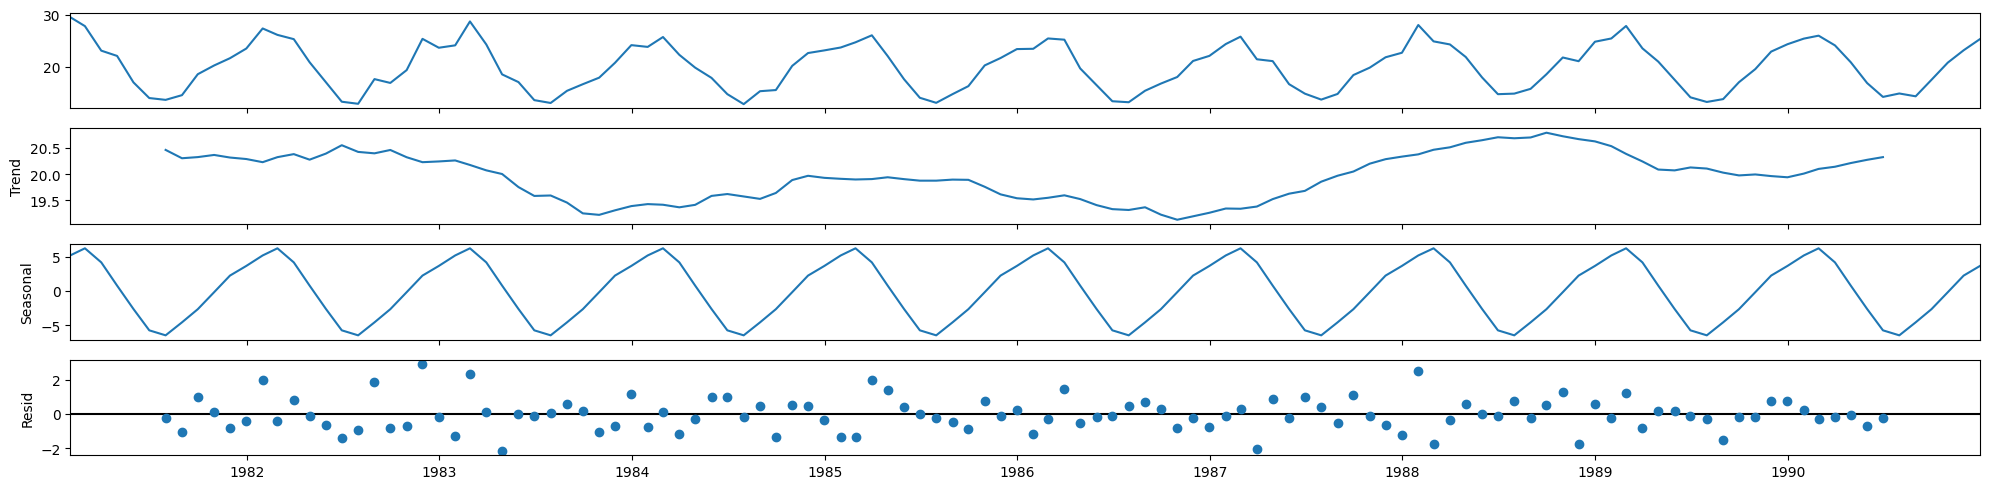

In [17]:
df_monthly_max = max_temp_data.resample('M').mean()

results3 = seasonal_decompose(df_monthly_max)

results3.plot()

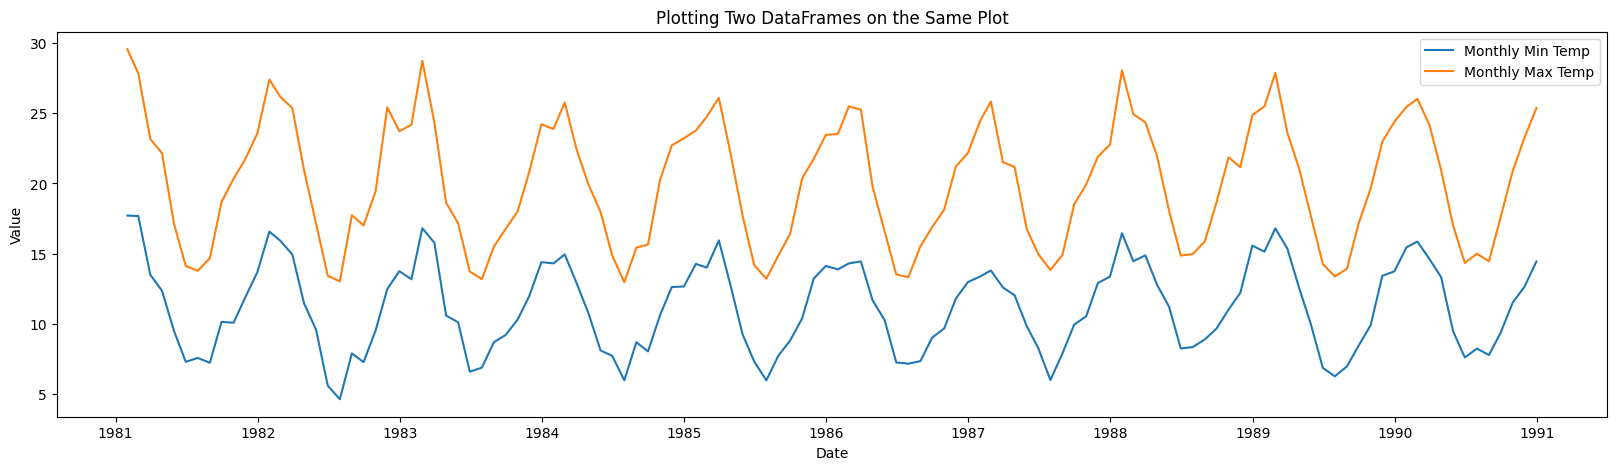

In [18]:
plt.rcParams['figure.figsize'] = [20, 5]

# Plot df1
plt.plot(df_monthly.index, df_monthly['min_temp'], label='Monthly Min Temp')

# Plot df2
plt.plot(df_monthly_max.index, df_monthly_max['max_temp'], label='Monthly Max Temp')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Plotting Two DataFrames on the Same Plot')
plt.legend()

# Show plot
plt.show()

#### Note: Going to Try a Different Approach Using GRU layer instead of LSTM

In [19]:
df = pd.concat([df_monthly, df_monthly_max], axis=1).reset_index()
df = df.rename(columns={'index':'date'})
train_set_dates = pd.to_datetime(df['date'])

columns = list(df.columns[1:3])

df_train = df[columns].astype(float)

In [20]:
# Normalize the data using the Standard scaler
standard_scaler = MinMaxScaler()
scalar = standard_scaler.fit(df_train)
scaled_training_df = scalar.transform(df_train)

In [21]:
trainX = []
trainY = []

future_no_of_months = 1 # num of days to predict the future values
past_no_of_months = 12 # number of days on which the prediction is computed

for i in range(past_no_of_months, len(scaled_training_df) - future_no_of_months+1):
    trainX.append(scaled_training_df[i - past_no_of_months:i, 0:df_train.shape[1]])
    trainY.append(scaled_training_df[i + future_no_of_months - 1:i + future_no_of_months, 0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

In [22]:
model2 = Sequential()
model2.add(Input(shape=(trainX.shape[1], trainX.shape[2])))
model2.add(GRU(64, activation='relu', return_sequences=True))
model2.add(GRU(32, activation='relu', return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(trainY.shape[1]))
model2.compile(optimizer='adam', loss='mse')
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 12, 64)         │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,497 (87.88 KB)

 Trainable params: 22,497 (87.88 KB)

 Non-trainable params: 0 (0.00 B)

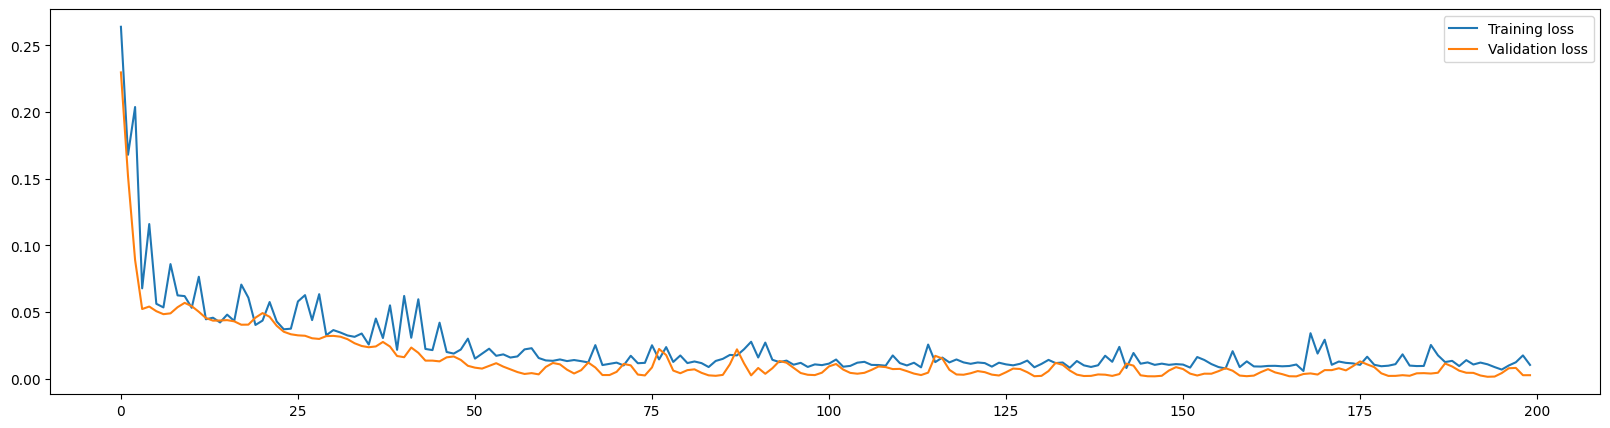

In [23]:
# fit the model
history = model2.fit(trainX, trainY, epochs=200, validation_split=0.1, verbose=False)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [24]:
n_past = 24
n_days_for_prediction=24  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_set_dates)[-n_past], periods=n_days_for_prediction, freq='1m').tolist() # instead of us_bd we can give '1d' etc.

predict_period_dates

#Make prediction
prediction = model2.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

# predict the future price
prediction_copies = np.repeat(prediction, df_train.shape[1], axis=-1)
y_pred_future = scalar.inverse_transform(prediction_copies)[:,0]

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'min_temp':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

original = df[['date', 'min_temp']]
original['date']=pd.to_datetime(original['date'])

/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_42109/4096841219.py:4: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  predict_period_dates = pd.date_range(list(train_set_dates)[-n_past], periods=n_days_for_prediction, freq='1m').tolist() # instead of us_bd we can give '1d' etc.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_42109/4096841219.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])


## Looks Like It Worked

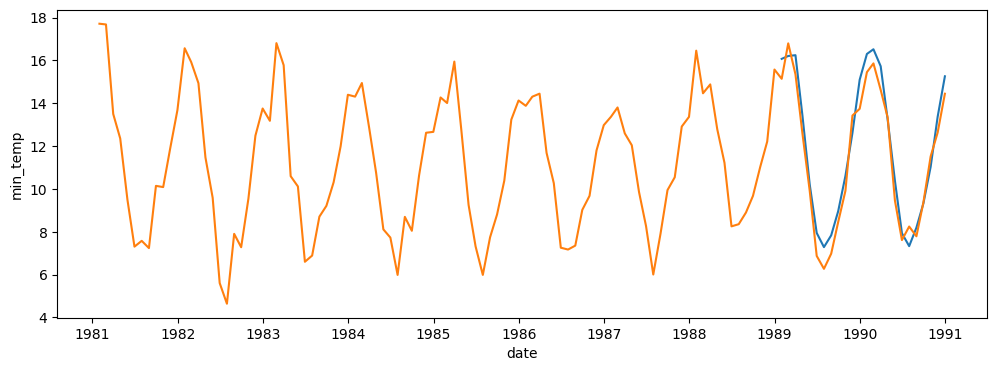

In [25]:
plt.figure(figsize=(12,4))
sns.lineplot(data=df_forecast, x='date', y='min_temp', )
sns.lineplot(data=original, x='date', y='min_temp')
plt.show()

### Let's Try Fitting Weekly Data

In [26]:
df_weekly_min = min_temp_data.resample('W').mean()
df_weekly_max = max_temp_data.resample('W').mean()

df2 = pd.concat([df_weekly_min, df_weekly_max], axis=1).reset_index()
df2 = df2.rename(columns={'index':'date'})
train_set_dates2 = pd.to_datetime(df2['date'])

columns = list(df2.columns[1:3])

df2_train = df2[columns].astype(float)

# Remove first and last since weekly resampling didn't fit into the 10 year data perfectly
df2_train = df2_train[1:-1]

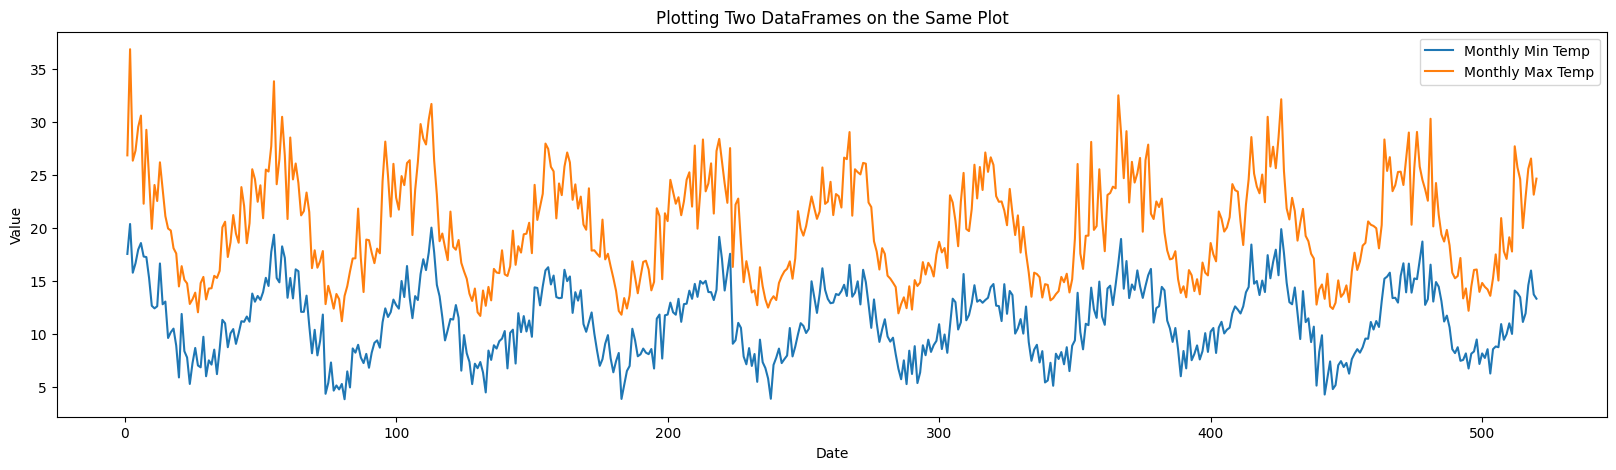

In [27]:
plt.rcParams['figure.figsize'] = [20, 5]

# Plot df1
plt.plot(df2_train.index, df2_train['min_temp'], label='Monthly Min Temp')

# Plot df2
plt.plot(df2_train.index, df2_train['max_temp'], label='Monthly Max Temp')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Plotting Two DataFrames on the Same Plot')
plt.legend()

# Show plot
plt.show()

In [28]:
# Normalize the data using the Standard scaler
standard_scaler = MinMaxScaler()
scalar = standard_scaler.fit(df2_train)
scaled_training_df2 = scalar.transform(df2_train)

# Make training data
trainX = []
trainY = []

future_no_of_weeks = 1 # num of weeks to predict the future values
past_no_of_weeks = 52 # number of weeks on which the prediction is computed

for i in range(past_no_of_weeks, len(scaled_training_df2) - future_no_of_weeks+1):
    trainX.append(scaled_training_df2[i - past_no_of_weeks:i, 0:df2_train.shape[1]])
    trainY.append(scaled_training_df2[i + future_no_of_weeks - 1:i + future_no_of_weeks, 0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

trainX_red = trainX[:-52]
trainY_red = trainY[:-52]

testX = trainX[-52:]

In [29]:
model3 = Sequential()
model3.add(Input(shape=(trainX.shape[1], trainX.shape[2])))
model3.add(GRU(64, activation='relu', return_sequences=True))
model3.add(GRU(32, activation='relu', return_sequences=False))
model3.add(Dropout(0.2))
model3.add(Dense(trainY.shape[1]))
model3.compile(optimizer='adam', loss='mse')
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 52, 64)         │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,497 (87.88 KB)

 Trainable params: 22,497 (87.88 KB)

 Non-trainable params: 0 (0.00 B)

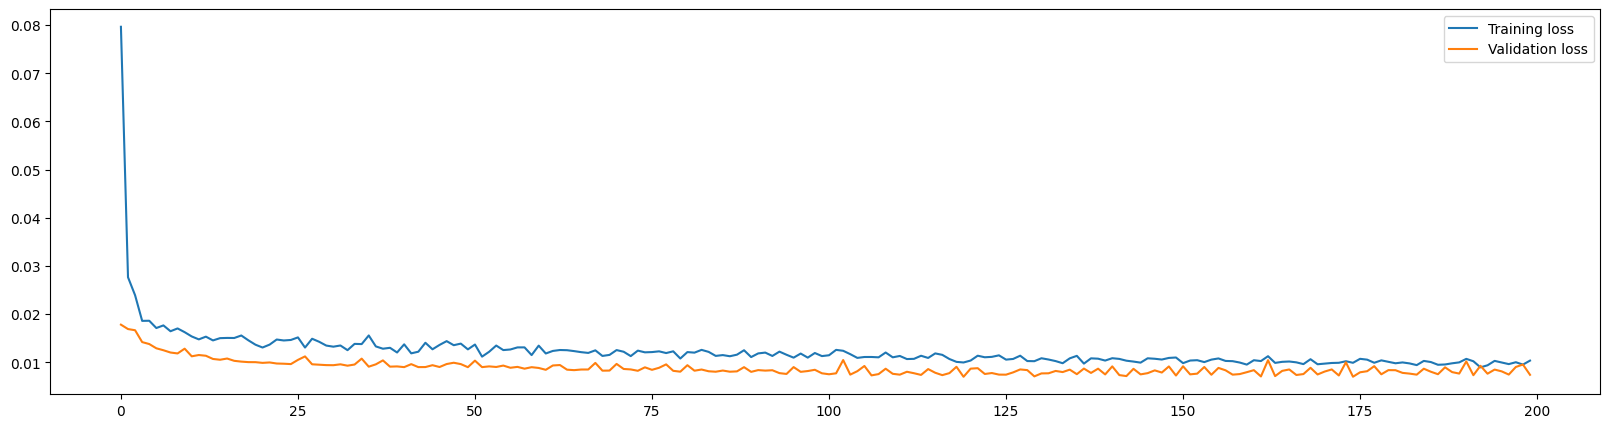

In [30]:
# fit the model
history = model3.fit(trainX_red, trainY_red, epochs=200, validation_split=0.1, verbose=False)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [31]:
n_past2 = 52
n_days_for_prediction2=52

predict_period_dates2 = pd.date_range(list(train_set_dates2)[-n_past2], periods=n_days_for_prediction2, freq='1w').tolist() # instead of us_bd we can give '1d' etc.

predict_period_dates2

#Make prediction
prediction2 = model3.predict(testX) #shape = (n, 1) where n is the n_days_for_prediction

# predict the future price
prediction_copies2 = np.repeat(prediction2, df2_train.shape[1], axis=-1)
y_pred_future2 = scalar.inverse_transform(prediction_copies2)[:,0]

# Convert timestamp to date
forecast_dates2 = []
for time_i in predict_period_dates2:
    forecast_dates2.append(time_i.date())

df_forecast2 = pd.DataFrame({'date':np.array(forecast_dates2), 'min_temp':y_pred_future2})
df_forecast2['date']=pd.to_datetime(df_forecast2['date'])

original2 = df2[['date', 'min_temp']]
original2['date']=pd.to_datetime(original2['date'])

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step

/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_42109/705743261.py:4: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  predict_period_dates2 = pd.date_range(list(train_set_dates2)[-n_past2], periods=n_days_for_prediction2, freq='1w').tolist() # instead of us_bd we can give '1d' etc.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_42109/705743261.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original2['date']=pd.to_datetime(original2['date'])


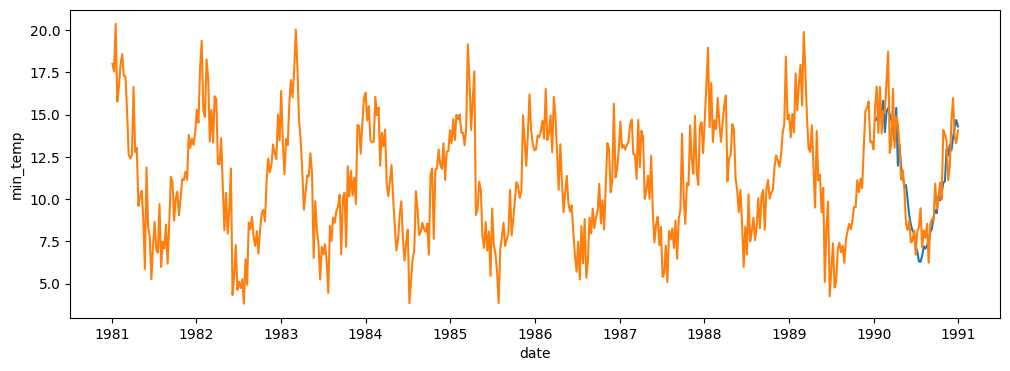

In [32]:
plt.figure(figsize=(12,4))
sns.lineplot(data=df_forecast2, x='date', y='min_temp', )
sns.lineplot(data=original2, x='date', y='min_temp')
plt.show()

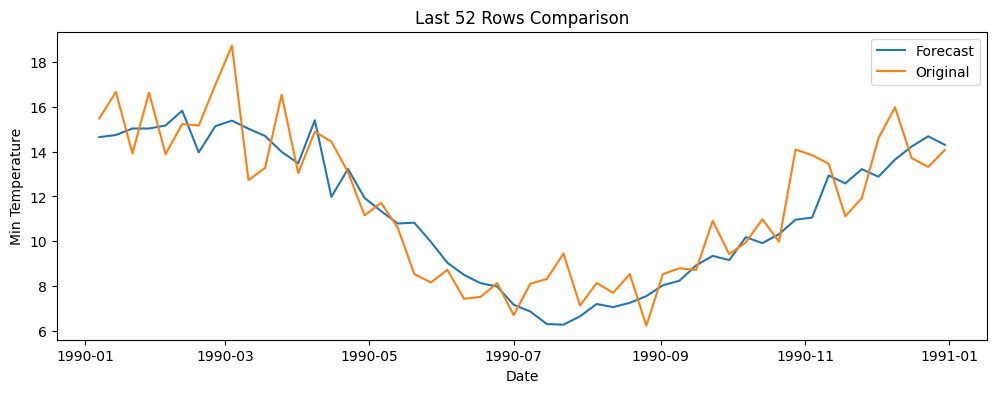

In [33]:
# Slice the dataframes to include only the last 52 rows
df_forecast2_last_52 = df_forecast2[-52:]
original2_last_52 = original2[-52:]

# Plotting
plt.figure(figsize=(12, 4))
sns.lineplot(data=df_forecast2_last_52, x='date', y='min_temp', label='Forecast')
sns.lineplot(data=original2_last_52, x='date', y='min_temp', label='Original')
plt.xlabel('Date')
plt.ylabel('Min Temperature')
plt.title('Last 52 Rows Comparison')
plt.legend()
plt.show()